In [1]:
import json
from collections import Counter

# Путь к JSON-аннотации BDD100K
json_path = r"C:\Users\odara\Downloads\data\labels\bdd100k_labels_images_train.json"

# Загружаем JSON-файл
with open(json_path, 'r') as f:
    annotations = json.load(f)

# Счётчик категорий
category_counts = Counter()

# Считаем объекты по категориям
for item in annotations:
    for obj in item.get("labels", []):
        category = obj.get("category")
        if category:
            category_counts[category] += 1

# Выводим распределение
print("Распределение категорий в BDD100K:")
for category in sorted(category_counts.keys()):
    print(f"{category}: {category_counts[category]} объектов")

total_objects = sum(category_counts.values())
print(f"\nВсего объектов: {total_objects}")

Распределение категорий в BDD100K:
bike: 7210 объектов
bus: 11672 объектов
car: 713211 объектов
drivable area: 125723 объектов
lane: 528643 объектов
motor: 3002 объектов
person: 91349 объектов
rider: 4517 объектов
traffic light: 186117 объектов
traffic sign: 239686 объектов
train: 136 объектов
truck: 29971 объектов

Всего объектов: 1941237


Загружаем аннотации bdd100k_labels_images_{split}.json.

Удаляем аннотации с классом train.

Объединяем классы motor и bike в один общий класс two_wheeler.

Сохраняем преобразованные аннотации в новую директорию labels_new.

Классы дорожных объектов для распознавания в данной работе: легковой автомобиль, дорожный знак, светофор, пешеход, грузовик, автобус, двухколесный транспорт (велосипед или мотоцикл), человек на двухколёсном транспорте (велосипеде или мотоцикле).

In [5]:
import json
import os

# Выбор split: 'train' или 'val'
split = 'train'

# Пути
input_path = fr"C:\Users\odara\Downloads\data\labels\bdd100k_labels_images_{split}.json"
output_dir = r"C:\Users\odara\Downloads\data\labels_new"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"bdd100k_labels_images_{split}.json")

# Классы для удаления и объединения
delete_classes = {'train', 'lane', 'drivable area'}
merge_classes = {'bike', 'motor'}
new_merged_class = 'two_wheeler'

# Загрузка аннотаций
with open(input_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Обработка аннотаций
processed_data = []
for item in data:
    new_labels = []
    for label in item.get("labels", []):
        category = label.get("category")

        if category in delete_classes:
            continue  # Пропустить нежелательные классы

        if category in merge_classes:
            label["category"] = new_merged_class

        new_labels.append(label)

    # Добавить только если остались аннотации
    if new_labels:
        item["labels"] = new_labels
        processed_data.append(item)

# Сохранение
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

print(f"Готово: сохранено {len(processed_data)} аннотированных изображений в {output_path}")

Готово: сохранено 69863 аннотированных изображений в C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train.json


In [6]:
import json
import os

# Выбор split: 'train' или 'val'
split = 'val'

# Пути
input_path = fr"C:\Users\odara\Downloads\data\labels\bdd100k_labels_images_{split}.json"
output_dir = r"C:\Users\odara\Downloads\data\labels_new"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"bdd100k_labels_images_{split}.json")

# Классы для удаления и объединения
delete_classes = {'train', 'lane', 'drivable area'}
merge_classes = {'bike', 'motor'}
new_merged_class = 'two_wheeler'

# Загрузка аннотаций
with open(input_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Обработка аннотаций
processed_data = []
for item in data:
    new_labels = []
    for label in item.get("labels", []):
        category = label.get("category")

        if category in delete_classes:
            continue  # Пропустить нежелательные классы

        if category in merge_classes:
            label["category"] = new_merged_class

        new_labels.append(label)

    # Добавить только если остались аннотации
    if new_labels:
        item["labels"] = new_labels
        processed_data.append(item)

# Сохранение
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

print(f"Готово: сохранено {len(processed_data)} аннотированных изображений в {output_path}")

Готово: сохранено 10000 аннотированных изображений в C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json


Проверяем и исключаем некорректные данные:

Изображения без аннотаций
Пустые аннотации
Дублирующиеся имена изображений в аннотации
Аннотации без поля "labels" вообще
Пустой "box2d" или значения x1 >= x2, y1 >= y2 (ошибочные боксы) в аннотации

In [12]:
import os
import json
import shutil

# Параметры
split = 'train'  # или 'val'
images_dir = fr"C:\Users\odara\Downloads\data\{split}\images"
annotations_path = fr"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_{split}.json"
bad_images_dir = fr"C:\Users\odara\Downloads\data\bad_samples\images"
bad_labels_dir = fr"C:\Users\odara\Downloads\data\bad_samples\labels"
os.makedirs(bad_images_dir, exist_ok=True)
os.makedirs(bad_labels_dir, exist_ok=True)

# Настройка допустимых классов
valid_classes = {
    "person", "car", "bus", "truck", "traffic sign", "traffic light",
    "two_wheeler", "rider"
}

# Загрузка аннотаций
with open(annotations_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

image_names_in_annot = set()
seen_images = set()
valid_annotations = []
bad_ann_count = 0
missing_annot_count = 0
duplicate_ann_count = 0

for entry in annotations:
    image_name = entry.get("name")
    image_path = os.path.join(images_dir, image_name)

    # Проверка на дубликат
    if image_name in seen_images:
        reason = "duplicate_image_name"
        duplicate_ann_count += 1
    else:
        seen_images.add(image_name)

        # Проверка поля labels
        labels = entry.get("labels")
        if labels is None:
            reason = "no_labels_field"
        elif not labels:
            reason = "empty_labels"
        else:
            valid = True
            for label in labels:
                cat = label.get("category")
                box = label.get("box2d")
                if cat not in valid_classes or not box:
                    valid = False
                    reason = f"invalid_label_or_box"
                    break
                if box["x1"] >= box["x2"] or box["y1"] >= box["y2"]:
                    valid = False
                    reason = "invalid_box_coordinates"
                    break
            if valid:
                valid_annotations.append(entry)
                image_names_in_annot.add(image_name)
                continue  # всё прошло, пропускаем к следующему

    # Если дошли сюда — аннотация плохая
    if os.path.exists(image_path):
        shutil.move(image_path, os.path.join(bad_images_dir, image_name))
    ann_output_path = os.path.join(bad_labels_dir, image_name.replace('.jpg', '.json'))
    with open(ann_output_path, 'w', encoding='utf-8') as f:
        json.dump(entry, f, ensure_ascii=False, indent=2)
    bad_ann_count += 1

# Проверка изображений без аннотаций
for fname in os.listdir(images_dir):
    if not fname.endswith(".jpg"):
        continue
    if fname not in image_names_in_annot:
        shutil.move(os.path.join(images_dir, fname), os.path.join(bad_images_dir, fname))
        missing_annot_count += 1

# Сохраняем очищенные аннотации
with open(annotations_path, 'w', encoding='utf-8') as f:
    json.dump(valid_annotations, f, ensure_ascii=False, indent=2)

# Отчет
print("Очистка завершена.")
print(f"Удалено изображений без аннотаций: {missing_annot_count}")
print(f"Удалено аннотаций с ошибками (и соответствующих изображений): {bad_ann_count}")
print(f"Найдено и удалено дубликатов изображений: {duplicate_ann_count}")

Очистка завершена.
Удалено изображений без аннотаций: 137
Удалено аннотаций с ошибками (и соответствующих изображений): 0
Найдено и удалено дубликатов изображений: 0


In [8]:
import os
import json
import shutil

# Параметры
split = 'val'  # или 'val'
images_dir = fr"C:\Users\odara\Downloads\data\{split}\images"
annotations_path = fr"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_{split}.json"
bad_images_dir = fr"C:\Users\odara\Downloads\data\bad_samples\images_val"
bad_labels_dir = fr"C:\Users\odara\Downloads\data\bad_samples\labels_val"
os.makedirs(bad_images_dir, exist_ok=True)
os.makedirs(bad_labels_dir, exist_ok=True)

# Настройка допустимых классов
valid_classes = {
    "person", "car", "bus", "truck", "traffic sign", "traffic light",
    "two_wheeler", "rider"
}

# Загрузка аннотаций
with open(annotations_path, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

image_names_in_annot = set()
seen_images = set()
valid_annotations = []
bad_ann_count = 0
missing_annot_count = 0
duplicate_ann_count = 0

for entry in annotations:
    image_name = entry.get("name")
    image_path = os.path.join(images_dir, image_name)

    # Проверка на дубликат
    if image_name in seen_images:
        reason = "duplicate_image_name"
        duplicate_ann_count += 1
    else:
        seen_images.add(image_name)

        # Проверка поля labels
        labels = entry.get("labels")
        if labels is None:
            reason = "no_labels_field"
        elif not labels:
            reason = "empty_labels"
        else:
            valid = True
            for label in labels:
                cat = label.get("category")
                box = label.get("box2d")
                if cat not in valid_classes or not box:
                    valid = False
                    reason = f"invalid_label_or_box"
                    break
                if box["x1"] >= box["x2"] or box["y1"] >= box["y2"]:
                    valid = False
                    reason = "invalid_box_coordinates"
                    break
            if valid:
                valid_annotations.append(entry)
                image_names_in_annot.add(image_name)
                continue  # всё прошло, пропускаем к следующему

    # Если дошли сюда — аннотация плохая
    if os.path.exists(image_path):
        shutil.move(image_path, os.path.join(bad_images_dir, image_name))
    ann_output_path = os.path.join(bad_labels_dir, image_name.replace('.jpg', '.json'))
    with open(ann_output_path, 'w', encoding='utf-8') as f:
        json.dump(entry, f, ensure_ascii=False, indent=2)
    bad_ann_count += 1

# Проверка изображений без аннотаций
for fname in os.listdir(images_dir):
    if not fname.endswith(".jpg"):
        continue
    if fname not in image_names_in_annot:
        shutil.move(os.path.join(images_dir, fname), os.path.join(bad_images_dir, fname))
        missing_annot_count += 1

# Сохраняем очищенные аннотации
with open(annotations_path, 'w', encoding='utf-8') as f:
    json.dump(valid_annotations, f, ensure_ascii=False, indent=2)

# Отчет
print("Очистка завершена.")
print(f"Удалено изображений без аннотаций: {missing_annot_count}")
print(f"Удалено аннотаций с ошибками (и соответствующих изображений): {bad_ann_count}")
print(f"Найдено и удалено дубликатов изображений: {duplicate_ann_count}")

Очистка завершена.
Удалено изображений без аннотаций: 0
Удалено аннотаций с ошибками (и соответствующих изображений): 0
Найдено и удалено дубликатов изображений: 0


Оверсемплинг классов (rider, two_wheeler, bus)

Загружаем аннотации bdd100k_labels_images_train.json.
Ищем изображения, содержащие объекты классов rider, two_wheeler, bus.
Копируем такие изображения и создает одну копию с суффиксом _copy.
Обновляем аннотации: оригинал + копия.
Сохраняем новые аннотации в bdd100k_labels_images_train_oversampled.json

In [16]:
import os
import json
import shutil

# Пути
input_json_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train.json"
output_json_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_oversampled.json"
input_images_dir = r"C:\Users\odara\Downloads\data\train\images"
output_images_dir = r"C:\Users\odara\Downloads\data\train_new\images"

# Целевые классы для оверсэмплинга
target_categories = {"rider", "two_wheeler", "bus"}

# Загрузка аннотаций
with open(input_json_path, 'r') as f:
    annotations = json.load(f)

# Готовим директорию вывода
os.makedirs(output_images_dir, exist_ok=True)

# Новые аннотации
new_annotations = []

for item in annotations:
    name = item["name"]
    labels = item.get("labels", [])

    # Добавляем оригинал
    src_path = os.path.join(input_images_dir, name)
    dst_path = os.path.join(output_images_dir, name)
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
        new_annotations.append(item)

    # Проверка на нужные классы
    has_target = any(label.get("category") in target_categories for label in labels)

    if has_target:
        # Создаем копию изображения
        name_copy = name.replace(".jpg", "_copy.jpg")
        dst_copy_path = os.path.join(output_images_dir, name_copy)
        shutil.copy2(src_path, dst_copy_path)

        # Создаем копию аннотации с новым именем
        item_copy = json.loads(json.dumps(item))  # глубокая копия
        item_copy["name"] = name_copy
        new_annotations.append(item_copy)

# Сохраняем новые аннотации
with open(output_json_path, 'w') as f:
    json.dump(new_annotations, f, indent=2)

print(f"Оверсэмплинг завершён. Сохранено {len(new_annotations)} аннотаций.")

Оверсэмплинг завершён. Сохранено 84047 аннотаций.


Андерсемплинг класса car (и, как побочка, других распространенных классов)

Загружаем аннотации и считает общее число объектов car.
Перебираем все изображения и удаляет только те, где есть только машины.
При удалении копируем изображения и отдельные JSON-файлы с аннотациями в отдельные папки.
Обновляем количество машин и останавливается, если порог (350 000) достигнут.
Сохраняем обновлённые аннотации в новый файл, не затирая исходный

In [28]:
import json
import os
import shutil
from tqdm import tqdm

images_dir = r"C:\Users\odara\Downloads\data\train_new\images"
labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_oversampled.json"

deleted_images_dir = r"C:\Users\odara\Downloads\data\deleted_car_samples\images"
deleted_labels_dir = r"C:\Users\odara\Downloads\data\deleted_car_samples\labels"

os.makedirs(deleted_images_dir, exist_ok=True)
os.makedirs(deleted_labels_dir, exist_ok=True)

with open(labels_path, "r") as f:
    annotations = json.load(f)

target_class = "car"
target_class_threshold = 350_000
protected_classes = {"rider", "two_wheeler", "bus"}  # Добавляем сюда

def count_objects(data, cls):
    total = 0
    for ann in data:
        cats = [obj["category"] for obj in ann.get("labels", [])]
        total += cats.count(cls)
    return total

total_cars = count_objects(annotations, target_class)
print(f"Всего объектов '{target_class}': {total_cars}")

filtered_annotations = []
deleted_count = 0

for ann in tqdm(annotations, desc="Processing images"):
    cats = [obj["category"] for obj in ann.get("labels", [])]
    unique_cats = set(cats)
    car_count = cats.count(target_class)

    # Новое условие: если есть хоть один "protected" класс — не удаляем
    if protected_classes.intersection(unique_cats):
        filtered_annotations.append(ann)
        continue

    # Условие удаления: есть только "car" и не меньше порога
    if unique_cats == {target_class}:
        if total_cars - car_count < target_class_threshold:
            filtered_annotations.append(ann)
            continue

        # Копируем изображение
        src_img_path = os.path.join(images_dir, ann["name"])
        dst_img_path = os.path.join(deleted_images_dir, ann["name"])
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)
            os.remove(src_img_path)

        # Сохраняем аннотацию отдельным JSON
        label_filename = os.path.splitext(ann["name"])[0] + ".json"
        dst_label_path = os.path.join(deleted_labels_dir, label_filename)
        with open(dst_label_path, "w") as f_label:
            json.dump(ann, f_label, indent=2)

        total_cars -= car_count
        deleted_count += 1
    else:
        filtered_annotations.append(ann)

print(f"Удалено изображений: {deleted_count}")
print(f"Осталось автомобилей '{target_class}': {total_cars}")

# Сохраняем обновлённые аннотации в новый файл, не затирая исходный
output_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_1.json"
with open(output_labels_path, "w") as f_out:
    json.dump(filtered_annotations, f_out, indent=2)

Всего объектов 'car': 856076


Processing images: 100%|███████████████████████████████████████████████████████| 84047/84047 [00:20<00:00, 4170.08it/s]


Удалено изображений: 4322
Осталось автомобилей 'car': 810444


Повторим то же самое, только теперь удаляем только те изображеняи, где есть только car или traffic sign, пока машин не станет ≤ 350 000 или traffic sign ≤ 150 000
(изображения, где есть только traffic sign не удаляются)

In [29]:
import json
import os
import shutil
from tqdm import tqdm

images_dir = r"C:\Users\odara\Downloads\data\train_new\images"
labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_1.json"

deleted_images_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\images"
deleted_labels_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\labels"

os.makedirs(deleted_images_dir, exist_ok=True)
os.makedirs(deleted_labels_dir, exist_ok=True)

with open(labels_path, "r") as f:
    annotations = json.load(f)

car_class = "car"
sign_class = "traffic sign"
car_threshold = 350_000
sign_threshold = 150_000

protected_classes = {"rider", "two_wheeler", "bus"}

def count_objects(data, cls):
    total = 0
    for ann in data:
        cats = [obj["category"] for obj in ann.get("labels", [])]
        total += cats.count(cls)
    return total

total_cars = count_objects(annotations, car_class)
total_signs = count_objects(annotations, sign_class)
print(f"Исходно: car = {total_cars}, traffic sign = {total_signs}")

filtered_annotations = []
deleted_count = 0

for ann in tqdm(annotations, desc="Processing images"):
    cats = [obj["category"] for obj in ann.get("labels", [])]
    unique_cats = set(cats)

    # Если есть хотя бы один защищённый класс — пропускаем удаление
    if protected_classes.intersection(unique_cats):
        filtered_annotations.append(ann)
        continue

    car_count = cats.count(car_class)
    sign_count = cats.count(sign_class)

    # Условие: только car и/или traffic sign, но не только traffic sign
    if unique_cats.issubset({car_class, sign_class}) and car_count > 0:
        if (total_cars - car_count < car_threshold) or (total_signs - sign_count < sign_threshold):
            filtered_annotations.append(ann)
            continue

        # Копируем изображение
        src_img_path = os.path.join(images_dir, ann["name"])
        dst_img_path = os.path.join(deleted_images_dir, ann["name"])
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)
            os.remove(src_img_path)

        # Сохраняем аннотацию как отдельный JSON
        label_filename = os.path.splitext(ann["name"])[0] + ".json"
        dst_label_path = os.path.join(deleted_labels_dir, label_filename)
        with open(dst_label_path, "w") as f_label:
            json.dump(ann, f_label, indent=2)

        total_cars -= car_count
        total_signs -= sign_count
        deleted_count += 1
    else:
        filtered_annotations.append(ann)

print(f"Удалено изображений: {deleted_count}")
print(f"Осталось объектов 'car': {total_cars}")
print(f"Осталось объектов 'traffic sign': {total_signs}")

# Сохраняем обновлённые аннотации в новый файл
output_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_2.json"
with open(output_labels_path, "w") as f_out:
    json.dump(filtered_annotations, f_out, indent=2)

Исходно: car = 810444, traffic sign = 295249


Processing images: 100%|███████████████████████████████████████████████████████| 79725/79725 [01:11<00:00, 1107.76it/s]


Удалено изображений: 12118
Осталось объектов 'car': 695493
Осталось объектов 'traffic sign': 251550


Повторим то же самое, только теперь удаляем только те изображеняи, где есть только car или traffic light, пока машин не станет ≤ 350 000 или traffic light ≤ 150 000
(изображения, где есть только traffic light не удаляются)

In [30]:
import json
import os
import shutil
from tqdm import tqdm

images_dir = r"C:\Users\odara\Downloads\data\train_new\images"
labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_2.json"

deleted_images_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\images"
deleted_labels_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\labels"

os.makedirs(deleted_images_dir, exist_ok=True)
os.makedirs(deleted_labels_dir, exist_ok=True)

with open(labels_path, "r") as f:
    annotations = json.load(f)

car_class = "car"
light_class = "traffic light"
car_threshold = 350_000
light_threshold = 150_000

protected_classes = {"rider", "two_wheeler", "bus"}

def count_objects(data, cls):
    total = 0
    for ann in data:
        cats = [obj["category"] for obj in ann.get("labels", [])]
        total += cats.count(cls)
    return total

total_cars = count_objects(annotations, car_class)
total_lights = count_objects(annotations, light_class)
print(f"Исходно: car = {total_cars}, traffic light = {total_lights}")

filtered_annotations = []
deleted_count = 0

for ann in tqdm(annotations, desc="Processing images"):
    cats = [obj["category"] for obj in ann.get("labels", [])]
    unique_cats = set(cats)

    # Если есть хотя бы один защищённый класс — не удаляем
    if protected_classes.intersection(unique_cats):
        filtered_annotations.append(ann)
        continue

    car_count = cats.count(car_class)
    light_count = cats.count(light_class)

    # Условие: только car и/или traffic light, но не только traffic light
    if unique_cats.issubset({car_class, light_class}) and car_count > 0:
        if (total_cars - car_count < car_threshold) or (total_lights - light_count < light_threshold):
            filtered_annotations.append(ann)
            continue

        # Копируем изображение
        src_img_path = os.path.join(images_dir, ann["name"])
        dst_img_path = os.path.join(deleted_images_dir, ann["name"])
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)
            os.remove(src_img_path)

        # Сохраняем аннотацию как отдельный JSON
        label_filename = os.path.splitext(ann["name"])[0] + ".json"
        dst_label_path = os.path.join(deleted_labels_dir, label_filename)
        with open(dst_label_path, "w") as f_label:
            json.dump(ann, f_label, indent=2)

        total_cars -= car_count
        total_lights -= light_count
        deleted_count += 1
    else:
        filtered_annotations.append(ann)

print(f"Удалено изображений: {deleted_count}")
print(f"Осталось объектов 'car': {total_cars}")
print(f"Осталось объектов 'traffic light': {total_lights}")

# Сохраняем обновлённые аннотации в новый файл
output_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_3.json"
with open(output_labels_path, "w") as f_out:
    json.dump(filtered_annotations, f_out, indent=2)

Исходно: car = 695493, traffic light = 234232


Processing images: 100%|███████████████████████████████████████████████████████| 67607/67607 [00:10<00:00, 6408.14it/s]


Удалено изображений: 2285
Осталось объектов 'car': 671219
Осталось объектов 'traffic light': 227220


Повторим то же самое, только теперь удаляем только те изображеняи, где есть только car или traffic light или traffic sign, пока машин не станет ≤ 350 000 или traffic light ≤ 150 000 или traffic sign ≤ 150 000

In [31]:
import json
import os
import shutil
from tqdm import tqdm

images_dir = r"C:\Users\odara\Downloads\data\train_new\images"
labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_3.json"

deleted_images_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\images"
deleted_labels_dir = r"C:\Users\odara\Downloads\data\deleted_car\samples\labels"

os.makedirs(deleted_images_dir, exist_ok=True)
os.makedirs(deleted_labels_dir, exist_ok=True)

with open(labels_path, "r") as f:
    annotations = json.load(f)

car_class = "car"
light_class = "traffic light"
sign_class = "traffic sign"

car_threshold = 350_000
light_sign_threshold = 150_000  # общий порог для traffic light и traffic sign

protected_classes = {"rider", "two_wheeler", "bus"}

def count_objects(data, cls):
    total = 0
    for ann in data:
        cats = [obj["category"] for obj in ann.get("labels", [])]
        total += cats.count(cls)
    return total

total_cars = count_objects(annotations, car_class)
total_lights = count_objects(annotations, light_class)
total_signs = count_objects(annotations, sign_class)

print(f"Исходно: car = {total_cars}, traffic light = {total_lights}, traffic sign = {total_signs}")

filtered_annotations = []
deleted_count = 0

for ann in tqdm(annotations, desc="Processing images"):
    cats = [obj["category"] for obj in ann.get("labels", [])]
    unique_cats = set(cats)

    # Защищаем изображения с rider, two_wheeler, bus
    if protected_classes.intersection(unique_cats):
        filtered_annotations.append(ann)
        continue

    car_count = cats.count(car_class)
    light_count = cats.count(light_class)
    sign_count = cats.count(sign_class)

    # Условие для удаления:
    # 1) классы на изображении - подмножество {car, traffic light, traffic sign}
    # 2) на изображении есть car (удаляем только если car есть)
    if unique_cats.issubset({car_class, light_class, sign_class}) and car_count > 0:
        # Проверяем пороги, удаляем только если они не достигнуты
        if (total_cars - car_count < car_threshold) or ((total_lights + total_signs) - (light_count + sign_count) < light_sign_threshold):
            filtered_annotations.append(ann)
            continue

        # Копируем изображение в папку удалённых
        src_img_path = os.path.join(images_dir, ann["name"])
        dst_img_path = os.path.join(deleted_images_dir, ann["name"])
        if os.path.exists(src_img_path):
            shutil.copy2(src_img_path, dst_img_path)
            os.remove(src_img_path)

        # Сохраняем отдельный JSON с аннотацией
        label_filename = os.path.splitext(ann["name"])[0] + ".json"
        dst_label_path = os.path.join(deleted_labels_dir, label_filename)
        with open(dst_label_path, "w") as f_label:
            json.dump(ann, f_label, indent=2)

        total_cars -= car_count
        total_lights -= light_count
        total_signs -= sign_count
        deleted_count += 1
    else:
        filtered_annotations.append(ann)

print(f"Удалено изображений: {deleted_count}")
print(f"Осталось объектов 'car': {total_cars}")
print(f"Осталось объектов 'traffic light': {total_lights}")
print(f"Осталось объектов 'traffic sign': {total_signs}")

# Сохраняем результат
output_labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_4.json"
with open(output_labels_path, "w") as f_out:
    json.dump(filtered_annotations, f_out, indent=2)

Исходно: car = 671219, traffic light = 227220, traffic sign = 251550


Processing images: 100%|███████████████████████████████████████████████████████| 65322/65322 [00:58<00:00, 1112.84it/s]


Удалено изображений: 12586
Осталось объектов 'car': 537462
Осталось объектов 'traffic light': 170191
Осталось объектов 'traffic sign': 198555


Итог балансировки

In [32]:
import json
from collections import Counter

labels_path = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_4.json"

with open(labels_path, "r") as f:
    annotations = json.load(f)

counter = Counter()

for ann in annotations:
    cats = [obj["category"] for obj in ann.get("labels", [])]
    counter.update(cats)

print("Итоговое количество объектов по классам:")
for cls, count in counter.most_common():
    print(f"{cls}: {count}")

Итоговое количество объектов по классам:
car: 537462
traffic sign: 198555
traffic light: 170191
person: 130512
truck: 37643
bus: 23344
two_wheeler: 20424
rider: 9034


Дальше андерсэмплинг будет слишком вредить другим малопредставленным классам, поэтому остановимся.

Осталось 52736 тренировочных изображений из 70000 до удаления изображений без аннотаций и овер и андерсамплинга

Форматируем аннотации в форматы необходмиые для обучения YOLO и RT-DETR

YOLO-аннотации

Каждое изображение имеет свой .txt файл с тем же именем. В этом файле каждая строка описывает один объект:

<class_id> <x_center> <y_center> <width> <height>

class_id — целое число (индекс класса, начиная с 0)
x_center, y_center — координаты центра объекта, нормализованные (делятся на ширину и высоту изображения)
width, height — ширина и высота объекта, также нормализованные

Значения x_center, y_center, width, height находятся в диапазоне [0, 1] (нормализованы).

In [33]:
import json
import os

# Пути
input_json = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_4.json"
output_dir = r"C:\Users\odara\Downloads\data\train_new\labels"

# Классы
class_map = {
    "car": 0,
    "traffic sign": 1,
    "traffic light": 2,
    "person": 3,
    "truck": 4,
    "bus": 5,
    "two_wheeler": 6,
    "rider": 7
}

# Разрешение изображений BDD100K
img_width = 1280
img_height = 720

# Убедимся, что папка существует
os.makedirs(output_dir, exist_ok=True)

# Загрузка аннотаций
with open(input_json, "r") as f:
    data = json.load(f)

# Обработка
for item in data:
    image_name = item["name"]
    label_filename = os.path.splitext(image_name)[0] + ".txt"
    label_path = os.path.join(output_dir, label_filename)

    lines = []
    for label in item.get("labels", []):
        category = label.get("category")
        box2d = label.get("box2d")

        if category in class_map and box2d:
            x1 = box2d["x1"]
            y1 = box2d["y1"]
            x2 = box2d["x2"]
            y2 = box2d["y2"]

            # YOLO формат — нормализованные координаты
            x_center = ((x1 + x2) / 2) / img_width
            y_center = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            class_id = class_map[category]
            line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            lines.append(line)

    with open(label_path, "w") as f:
        f.write("\n".join(lines))

In [24]:
import json
import os

# Пути
input_json = r"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
output_dir = r"C:\Users\odara\Downloads\data\val\labels"

# Классы
class_map = {
    "car": 0,
    "traffic sign": 1,
    "traffic light": 2,
    "person": 3,
    "truck": 4,
    "bus": 5,
    "two_wheeler": 6,
    "rider": 7
}

# Разрешение изображений BDD100K
img_width = 1280
img_height = 720

# Убедимся, что папка существует
os.makedirs(output_dir, exist_ok=True)

# Загрузка аннотаций
with open(input_json, "r") as f:
    data = json.load(f)

# Обработка
for item in data:
    image_name = item["name"]
    label_filename = os.path.splitext(image_name)[0] + ".txt"
    label_path = os.path.join(output_dir, label_filename)

    lines = []
    for label in item.get("labels", []):
        category = label.get("category")
        box2d = label.get("box2d")

        if category in class_map and box2d:
            x1 = box2d["x1"]
            y1 = box2d["y1"]
            x2 = box2d["x2"]
            y2 = box2d["y2"]

            # YOLO формат — нормализованные координаты
            x_center = ((x1 + x2) / 2) / img_width
            y_center = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            class_id = class_map[category]
            line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            lines.append(line)

    with open(label_path, "w") as f:
        f.write("\n".join(lines))

Проверка на корректные аннотации

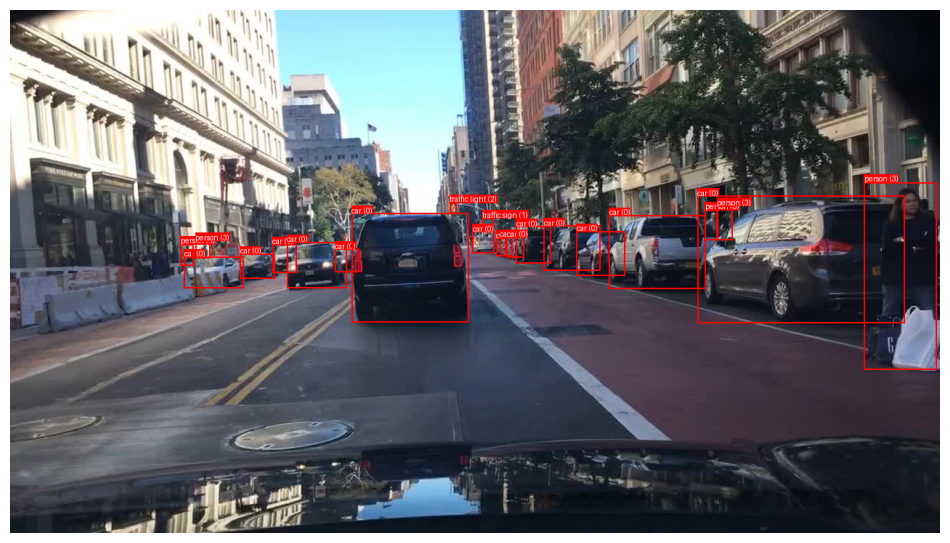

In [34]:
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

base_path = r"C:\Users\odara\Downloads\data"
subset = "train_new"  # "train_new" или "val"
# sample_image_name = "b3b44b49-7336e3ee.jpg"
sample_image_name = "0a0eaeaf-9ad0c6dd.jpg"

images_dir = os.path.join(base_path, subset, "images")
labels_dir = os.path.join(base_path, subset, "labels")

class_names = ["car", "traffic sign", "traffic light", "person", "truck", "bus", "two_wheeler", "rider"] # от 0 до 7


def draw_yolo_annotations_for_jupyter(image_path, label_path):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    font = ImageFont.load_default()

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:5])

        x1 = (x_center - width / 2) * img_width
        y1 = (y_center - height / 2) * img_height
        x2 = (x_center + width / 2) * img_width
        y2 = (y_center + height / 2) * img_height

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        label_text = f"{class_names[class_id]} ({class_id})"
        bbox = draw.textbbox((x1, y1), label_text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        draw.rectangle([x1, y1 - text_height, x1 + text_width, y1], fill="red")
        draw.text((x1, y1 - text_height), label_text, fill="white", font=font)

    return image

# Пути
image_path = os.path.join(images_dir, sample_image_name)
label_path = os.path.join(labels_dir, sample_image_name.replace(".jpg", ".txt"))

# Проверка и отображение
if os.path.exists(image_path) and os.path.exists(label_path):
    img = draw_yolo_annotations_for_jupyter(image_path, label_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
else:
    print("Файл изображения или аннотации не найден.")

In [ ]:
RT-DETR-аннотации (COCO-аннотации)

COCO-аннотации — это один .json файл со структурой:

{
  "images": [
    {"id": 1, "file_name": "0001.jpg", "width": 1280, "height": 720},
    ...
  ],
  "annotations": [
    {
      "id": 1,
      "image_id": 1,
      "category_id": 0,
      "bbox": [x, y, width, height],  // В пикселях!
      "area": w * h,
      "iscrowd": 0
    },
    ...
  ],
  "categories": [
    {"id": 0, "name": "car"},
    {"id": 1, "name": "traffic sign"},
    ...
  ]
}

In [1]:
import json
import os
from tqdm import tqdm

# Пути
bdd_json_path = rf"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_train_undersampled_4.json"
images_dir = rf"C:\Users\odara\Downloads\data\train_new\images"
output_json = rf"C:\Users\odara\Downloads\data\rtdetr_labels\instances_train.json"

# Размер изображений BDD100K
img_width = 1280
img_height = 720

# Классы, которые используем
class_map = {
    "car": 0,
    "traffic sign": 1,
    "traffic light": 2,
    "person": 3,
    "truck": 4,
    "bus": 5,
    "two_wheeler": 6,
    "rider": 7
}

# COCO-структура
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{"id": v, "name": k} for k, v in class_map.items()]
}

# Счетчики
image_id = 0
annotation_id = 0

# Загружаем BDD JSON
with open(bdd_json_path, "r") as f:
    bdd_data = json.load(f)

for item in tqdm(bdd_data):
    file_name = item["name"]
    image_path = os.path.join(images_dir, file_name)
    if not os.path.exists(image_path):
        continue  # Пропускаем, если изображения нет

    coco_output["images"].append({
        "id": image_id,
        "file_name": file_name,
        "width": img_width,
        "height": img_height
    })

    for label in item.get("labels", []):
        category = label.get("category")
        if category not in class_map or "box2d" not in label:
            continue

        box = label["box2d"]
        x1 = box["x1"]
        y1 = box["y1"]
        x2 = box["x2"]
        y2 = box["y2"]
        w = x2 - x1
        h = y2 - y1

        coco_output["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": class_map[category],
            "bbox": [x1, y1, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        annotation_id += 1

    image_id += 1

# Сохраняем COCO JSON
os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(coco_output, f)

print(f"Сохранено в: {output_json}")

100%|█████████████████████████████████████████████████████████████████████████| 52736/52736 [00:03<00:00, 13604.61it/s]


Сохранено в: C:\Users\odara\Downloads\data\rtdetr_labels\instances_train.json


In [2]:
import json
import os
from tqdm import tqdm

# Пути
bdd_json_path = rf"C:\Users\odara\Downloads\data\labels_new\bdd100k_labels_images_val.json"
images_dir = rf"C:\Users\odara\Downloads\data\val\images"
output_json = rf"C:\Users\odara\Downloads\data\rtdetr_labels\instances_val.json"

# Размер изображений BDD100K
img_width = 1280
img_height = 720

# Классы, которые используем
class_map = {
    "car": 0,
    "traffic sign": 1,
    "traffic light": 2,
    "person": 3,
    "truck": 4,
    "bus": 5,
    "two_wheeler": 6,
    "rider": 7
}

# COCO-структура
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{"id": v, "name": k} for k, v in class_map.items()]
}

# Счетчики
image_id = 0
annotation_id = 0

# Загружаем BDD JSON
with open(bdd_json_path, "r") as f:
    bdd_data = json.load(f)

for item in tqdm(bdd_data):
    file_name = item["name"]
    image_path = os.path.join(images_dir, file_name)
    if not os.path.exists(image_path):
        continue  # Пропускаем, если изображения нет

    coco_output["images"].append({
        "id": image_id,
        "file_name": file_name,
        "width": img_width,
        "height": img_height
    })

    for label in item.get("labels", []):
        category = label.get("category")
        if category not in class_map or "box2d" not in label:
            continue

        box = label["box2d"]
        x1 = box["x1"]
        y1 = box["y1"]
        x2 = box["x2"]
        y2 = box["y2"]
        w = x2 - x1
        h = y2 - y1

        coco_output["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": class_map[category],
            "bbox": [x1, y1, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        annotation_id += 1

    image_id += 1

# Сохраняем COCO JSON
os.makedirs(os.path.dirname(output_json), exist_ok=True)
with open(output_json, "w") as f:
    json.dump(coco_output, f)

print(f"Сохранено в: {output_json}")

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16844.15it/s]


Сохранено в: C:\Users\odara\Downloads\data\rtdetr_labels\instances_val.json


Проверим корректность форматированных под COCO-формат аннотаций:

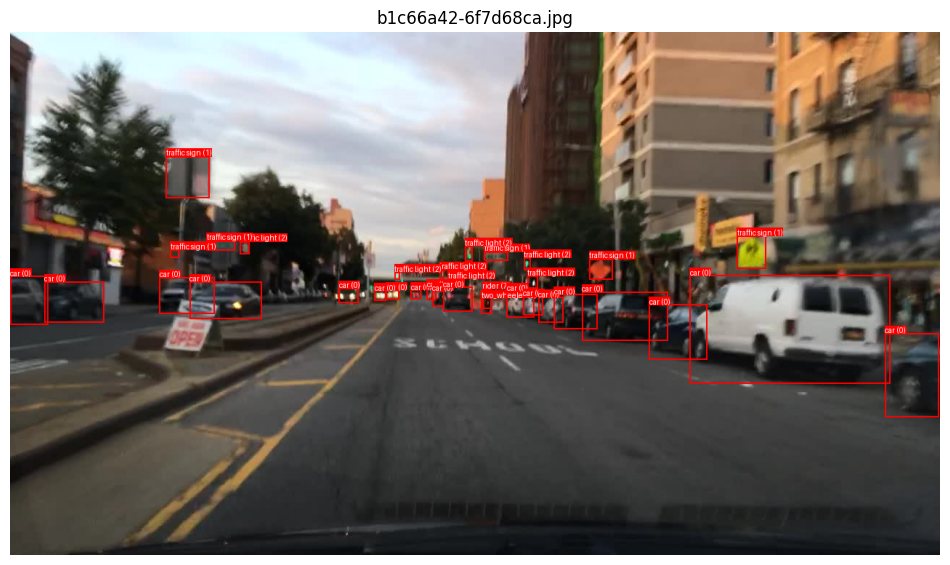

In [3]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

subset = "val"  # "train" или "val"

# Пути к аннотациям и картинкам
coco_annotations_path = rf"C:\Users\odara\Downloads\data\rtdetr_labels\instances_{subset}.json"
images_dir = rf"C:\Users\odara\Downloads\data\{subset}\images"

# Загружаем COCO аннотации
with open(coco_annotations_path, 'r') as f:
    coco_data = json.load(f)

# Словарь image_id -> информация об изображении
images_info = {img['id']: img for img in coco_data['images']}

# Словарь category_id -> имя класса
categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

# Для примера — первое изображение из выбранного поднабора
sample_image_id = coco_data['images'][0]['id']
sample_image_info = images_info[sample_image_id]
image_path = os.path.join(images_dir, sample_image_info['file_name'])

# Загружаем изображение
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Изображаем bounding boxes всех аннотаций для этого изображения
for ann in coco_data['annotations']:
    if ann['image_id'] == sample_image_id:
        bbox = ann['bbox']  # формат COCO: [x_min, y_min, width, height]
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        
        category_id = ann['category_id']
        category_name = categories.get(category_id, "N/A")
        
        # Рисуем рамку
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
        
        # Рисуем подпись
        label = f"{category_name} ({category_id})"
        bbox_text = draw.textbbox((x_min, y_min), label, font=font)
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]
        
        draw.rectangle([x_min, y_min - text_height, x_min + text_width, y_min], fill="red")
        draw.text((x_min, y_min - text_height), label, fill="white", font=font)

plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis("off")
plt.title(sample_image_info["file_name"])
plt.show()